# Análisis Exploratorio de Datos (EDA)

Para comenzar con este eda, debemos haber previamente ejecutado el ETL sobre el dataset original de Yelp. Se explicará en la documentación como se creó el dataset a travez de todos los archivos originales, y como se han cruzado los ID.

1. Carga y limpieza inicial
En esta primera etapa, se cargará el archivo meta_df.parquet directamente del almacenamiento en la nube (Google cloud storage) y se realizará una limpieza inicial del DataFrame. Eliminaremos las columnas que no son relevantes para nuestro análisis y filtraremos las que nos interesan, incluyendo información sobre reseñas, ubicaciones, categorías, calificaciones y otros detalles. Esto nos permitirá enfocarnos en los datos más útiles para nuestro cliente.

In [1]:
import polars as pl
import pygwalker as pyg

from google.oauth2.service_account import Credentials
from google.cloud import storage
import gcsfs
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Ignorar todos los warnings
warnings.filterwarnings("ignore")

In [2]:
# Configuración de la autenticación y creación de FileSystem
fs = gcsfs.GCSFileSystem(token="credencial_karen_propietario.json")

# Ruta al archivo Parquet que incluye wildcard para múltiples archivos
path = 'gs://bucket-proyecto-final-1/datos-limpios/yelp/meta_df.parquet'


# Lee los archivos Parquet directamente en un DataFrame de Polars
# Nota: Polars puede leer directamente de un path, pero para usar con gcsfs, necesitamos abrir los archivos uno por uno
def read_parquet_files(path):
    files = fs.glob(path)
    frames = [pl.read_parquet(fs.open(file)) for file in files]
    return pl.concat(frames)

df = read_parquet_files(path)

In [3]:
df.head(1)

shape: (1, 22)
┌────────────┬────────────┬────────────┬─────────┬───┬─────────┬───────────┬───────────┬───────────┐
│ review_id  ┆ user_id    ┆ business_i ┆ stars_x ┆ … ┆ is_open ┆ attribute ┆ categorie ┆ hours     │
│ ---        ┆ ---        ┆ d          ┆ ---     ┆   ┆ ---     ┆ s         ┆ s         ┆ ---       │
│ str        ┆ str        ┆ ---        ┆ i64     ┆   ┆ i64     ┆ ---       ┆ ---       ┆ str       │
│            ┆            ┆ str        ┆         ┆   ┆         ┆ str       ┆ list[str] ┆           │
╞════════════╪════════════╪════════════╪═════════╪═══╪═════════╪═══════════╪═══════════╪═══════════╡
│ KU_O5udG6z ┆ mh_-eMZ6K5 ┆ XQfwVwDr-v ┆ 3       ┆ … ┆ 1       ┆ {"NoiseLe ┆ ["Restaur ┆ {"Monday" │
│ pxOg-VcAEo ┆ RLWhZyISBh ┆ 0ZS3_CbbE5 ┆         ┆   ┆         ┆ vel": "u' ┆ ants",    ┆ : "7:30-1 │
│ dg         ┆ wA         ┆ Xw         ┆         ┆   ┆         ┆ average'" ┆ "Breakfas ┆ 5:0",     │
│            ┆            ┆            ┆         ┆   ┆         ┆ , "…      ┆ t & B…    ┆ "Tuesd…   │
└────────────┴────────────┴────────────┴─────────┴───┴─────────┴───────────┴───────────┴───────────┘

In [4]:
print(df.schema)

Schema([('review_id', String), ('user_id', String), ('business_id', String), ('stars_x', Int64), ('useful', Int64), ('funny', Int64), ('cool', Int64), ('text', String), ('date', Datetime(time_unit='ns', time_zone=None)), ('name', String), ('address', String), ('city', String), ('state', String), ('postal_code', String), ('latitude', Float64), ('longitude', Float64), ('stars_y', Float64), ('review_count', Int64), ('is_open', Int64), ('attributes', String), ('categories', List(String)), ('hours', String)])


In [5]:
#columnas que consideramos utiles para el analisis
columnas_utiles = [
    'review_id', 'user_id', 'business_id', 'stars_x', 'attributes', 'text', 'date',
    'city', 'state', 'latitude', 'longitude', 'categories' , 'name', 'review_count'
]

#filtrar las columnas que son utiles
df = df[columnas_utiles]

In [6]:
df.head(1)

shape: (1, 14)
┌────────────┬───────────┬───────────┬─────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ review_id  ┆ user_id   ┆ business_ ┆ stars_x ┆ … ┆ longitude ┆ categorie ┆ name      ┆ review_co │
│ ---        ┆ ---       ┆ id        ┆ ---     ┆   ┆ ---       ┆ s         ┆ ---       ┆ unt       │
│ str        ┆ str       ┆ ---       ┆ i64     ┆   ┆ f64       ┆ ---       ┆ str       ┆ ---       │
│            ┆           ┆ str       ┆         ┆   ┆           ┆ list[str] ┆           ┆ i64       │
╞════════════╪═══════════╪═══════════╪═════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ KU_O5udG6z ┆ mh_-eMZ6K ┆ XQfwVwDr- ┆ 3       ┆ … ┆ -75.22363 ┆ ["Restaur ┆ Turning   ┆ 169       │
│ pxOg-VcAEo ┆ 5RLWhZyIS ┆ v0ZS3_Cbb ┆         ┆   ┆ 9         ┆ ants",    ┆ Point of  ┆           │
│ dg         ┆ BhwA      ┆ E5Xw      ┆         ┆   ┆           ┆ "Breakfas ┆ North     ┆           │
│            ┆           ┆           ┆         ┆   ┆           ┆ t & B…    ┆ Wales     ┆           │
└────────────┴───────────┴───────────┴─────────┴───┴───────────┴───────────┴───────────┴───────────┘

2. Estados con más reseñas
En este paso, contaremos el número de reseñas por estado, las ordenaremos de mayor a menor y generaremos un gráfico para visualizar los estados con mayor actividad de reseñas. Este análisis nos ayudará a identificar los mercados más relevantes para la expansión de la cadena de restaurantes.
* Consideraremos los estados que incluyan una buena cantidad de reseñas, ignoraremos las que tienen un numero insignificativo de estas.

In [14]:
import polars as pl
import plotly.express as px

# Filtrar los datos excluyendo registros con "valor incompleto" en el estado
df_filtrado = df.filter(pl.col("state") != "valor incompleto")

# Contar el número de reseñas por estado y obtener latitud y longitud
reseñas_por_estado = (
    df_filtrado.group_by("state")
    .agg(
        pl.count().alias("review_count"),
        pl.first("latitude").alias("latitude"),   # Obtener la primera latitud para cada estado
        pl.first("longitude").alias("longitude")   # Obtener la primera longitud para cada estado
    )
    .sort("review_count", descending=True)
)

# Filtrar los estados con al menos 10,000 reseñas
reseñas_significativas = reseñas_por_estado.filter(pl.col("review_count") >= 10000)

# Configurar una gráfica de barras con escalas de color verde y mejoras visuales
fig = px.bar(
    reseñas_significativas.to_dicts(),
    x="state",
    y="review_count",
    title="Estados con Mayor Número de Reseñas de Restaurantes",
    labels={"review_count": "Número de Reseñas", "state": "Estado"},
    color="review_count",  # Escala de color basada en el recuento de reseñas
    color_continuous_scale="Greens"  # Escala de colores verdes
)

# Mejoras visuales
fig.update_layout(
    title={
        'text': "Estados con Mayor Número de Reseñas de Restaurantes",
        'y':0.95,  # Ajustar para mayor espacio vertical
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Estado",
    yaxis_title="Número de Reseñas",
    coloraxis_colorbar=dict(
        title="Cantidad de Reseñas",
        tickvals=[200000, 500000, 800000, 1100000],  # Valores basados en el rango proporcionado
        ticktext=["200k", "500k", "800k", "1.1M"]
    ),
    plot_bgcolor="white",
    bargap=0.2,  # Aumenta el espacio entre barras para claridad
)

# Añadir etiquetas de valor a cada barra y ajustar el tamaño del texto
fig.update_traces(texttemplate='%{y}', textposition='outside', textfont_size=10)

# Mostrar la gráfica
fig.show()





3. En este análisis, identificaremos las categorías de negocios con más reseñas, lo que puede indicar su popularidad y relevancia en el mercado. Filtraremos categorías relacionadas con la industria de alimentos y restaurantes para proporcionar información valiosa para el cliente.

In [15]:
import polars as pl
import plotly.express as px

# Crear un DataFrame simplificado con solo las columnas necesarias
df_simple = df.select(['categories', 'review_count'])

# Expandir la lista de categorías en filas individuales
df_simple = df_simple.explode('categories')

# Filtrar las categorías relevantes relacionadas con la industria de alimentos y restaurantes
categorias_relevantes = [
    'Restaurants', 'Food', 'American (Traditional)', 'American (New)',
    'Breakfast & Brunch', 'Sandwiches', 'Seafood', 'Pizza', 'Coffee & Tea',
    'Italian', 'Burgers', 'Mexican', 'Salad', 'Cocktail Bars', 'Fast Food'
]
df_simple = df_simple.filter(pl.col("categories").is_in(categorias_relevantes))

# Contar la cantidad de reseñas por categoría
reseñas_por_categoria = (
    df_simple
    .group_by("categories")
    .agg(pl.count().alias("review_count"))
    .sort("review_count", descending=True)
    .head(10)
)

# Convertir a un diccionario para graficar
reseñas_por_categoria_dict = reseñas_por_categoria.to_dicts()

# Graficar las categorías con más reseñas y personalizar la visualización
fig = px.bar(
    reseñas_por_categoria_dict,
    x='categories', 
    y='review_count',
    title='Categorías con Mayor Número de Reseñas (Relevantes)',
    labels={'review_count': 'Número de Reseñas', 'categories': 'Categoría'},
    color='review_count',
    color_continuous_scale='Greens'
)

# Ajustes adicionales de diseño y estética
fig.update_layout(
    title={
        'text': 'Categorías con Mayor Número de Reseñas (Relevantes)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Categoría",
    yaxis_title="Número de Reseñas",
    plot_bgcolor="white",
    bargap=0.3  # Ajuste para mayor claridad entre las barras
)

# Añadir etiquetas de valor en la parte superior de cada barra
fig.update_traces(texttemplate='%{y}', textposition='outside', textfont_size=10)

# Mostrar la gráfica
fig.show()




In [16]:
import polars as pl
import plotly.express as px

# Crear un DataFrame simplificado con solo las columnas necesarias
df_categories = df.select(['categories', 'review_count'])

# Expandir la lista de categorías en filas individuales
df_categories = df_categories.explode('categories')

# Contar la cantidad de reseñas por categoría
reseñas_por_categoria = (
    df_categories
    .group_by("categories")
    .agg(pl.count().alias("review_count"))
    .sort("review_count", descending=True)
    .head(10)
)

# Convertir a un diccionario para graficar
reseñas_por_categoria_dict = reseñas_por_categoria.to_dicts()

# Graficar las categorías con más reseñas en tonos de verde
fig = px.bar(
    reseñas_por_categoria_dict,
    x='categories', 
    y='review_count',
    title='Categorías con Mayor Número de Reseñas',
    labels={'review_count': 'Número de Reseñas', 'categories': 'Categoría'},
    color='review_count',
    color_continuous_scale='Greens'
)

# Ajustes adicionales para mejorar la visualización
fig.update_layout(
    title={
        'text': 'Categorías gastronomicas con Mayor Número de Reseñas',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Categoría",
    yaxis_title="Número de Reseñas",
    plot_bgcolor="white",
    bargap=0.3  # Espacio entre barras para claridad
)

# Añadir etiquetas de valor en la parte superior de cada barra
fig.update_traces(texttemplate='%{y}', textposition='outside', textfont_size=10)

# Mostrar la gráfica
fig.show()


___

10. Análisis de la Distribución Temporal de las Reseñas

Este análisis examina cuándo los clientes tienden a dejar reseñas en función del día de la semana y la hora del día. Al agregar columnas que representan el día y la hora, podemos identificar los patrones temporales de actividad en las reseñas. Esto proporciona información sobre los momentos de mayor interacción con los clientes, lo que puede ser útil para optimizar estrategias de marketing o gestión de la operación en función de los días y horarios con mayor actividad.

In [17]:
import polars as pl

# Crear nuevas columnas con el día de la semana, hora del día y año directamente de la columna `date`
df = df.with_columns([
    pl.col("date").dt.weekday().alias("day_of_week"),  # Día de la semana (0=Lunes, 6=Domingo)
    pl.col("date").dt.hour().alias("hour_of_day"),     # Hora del día
    pl.col("date").dt.year().alias("year")             # Año
])


In [18]:
import plotly.express as px
import polars as pl

# Contar la cantidad de reseñas por día de la semana
resenas_por_dia = (
    df.group_by("day_of_week")
    .agg(pl.count().alias("count"))
    .sort("day_of_week")
)

# Graficar directamente con Plotly Express en tonos verdes
fig_dia = px.bar(
    resenas_por_dia.to_dicts(),
    x='day_of_week',
    y='count',
    title='Distribución de Reseñas por Día de la Semana',
    labels={'count': 'Cantidad de Reseñas', 'day_of_week': 'Día de la Semana'},
    color='count',
    color_continuous_scale='Greens'
)

# Añadir etiquetas de valor en la parte superior de cada barra y ajustes de diseño
fig_dia.update_traces(texttemplate='%{y}', textposition='outside')
fig_dia.update_layout(
    title={
        'text': 'Distribución de Reseñas por Día de la Semana',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Día de la Semana",
    yaxis_title="Cantidad de Reseñas",
    plot_bgcolor="white",
    bargap=0.3
)

# Mostrar la gráfica
fig_dia.show()



In [20]:
import plotly.express as px
import polars as pl

# Contar la cantidad de reseñas por hora del día
resenas_por_hora = (
    df.group_by("hour_of_day")
    .agg(pl.count().alias("count"))
    .sort("hour_of_day")
)

# Graficar directamente con Plotly Express en tonos cálidos
fig_hora = px.bar(
    resenas_por_hora.to_dicts(),
    x='hour_of_day',
    y='count',
    title='Distribución de Reseñas por Hora del Día',
    labels={'count': 'Cantidad de Reseñas', 'hour_of_day': 'Hora del Día'},
    color='count',
    color_continuous_scale='Greens'
)

# Añadir etiquetas de valor en la parte superior de cada barra y ajustes de diseño
fig_hora.update_traces(texttemplate='%{y}', textposition='outside')
fig_hora.update_layout(
    title={
        'text': 'Distribución de Reseñas por Hora del Día',
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Hora del Día",
    yaxis_title="Cantidad de Reseñas",
    plot_bgcolor="white",
    bargap=0.3
)

# Mostrar la gráfica
fig_hora.show()



In [21]:
import polars as pl
import plotly.express as px

# Crear un nuevo DataFrame con solo las columnas 'date' y 'review_count'
df_ano_reseñas = df.select([
    pl.col("date").dt.year().alias("year"),  # Extraer el año
    pl.lit(1).alias("review_count")            # Contar cada reseña como 1
])

# Agrupar por año y contar las reseñas
df_ano_reseñas = df_ano_reseñas.group_by("year").agg(
    pl.sum("review_count").alias("total_reviews")  # Sumar el conteo de reseñas por año
).sort("year")  # Ordenar por año

# Convertir a un formato adecuado para Plotly
df_ano_reseñas_pd = df_ano_reseñas.to_pandas()

# Graficar la secuencia de reseñas por año
fig = px.line(df_ano_reseñas_pd, x='year', y='total_reviews',
              title='Cantidad de Reseñas por Año',
              labels={'total_reviews': 'Cantidad de Reseñas', 'year': 'Año'},
              markers=True,  # Usar marcadores para visualizar puntos de datos
              line_shape='linear',  # Mejor línea conectando los puntos
              color_discrete_sequence=["#2ca02c"])  # Paleta verde

# Mejorar la visualización
fig.update_layout(
    title={'x': 0.5, 'xanchor': 'center'},  # Centrar título
    xaxis_title="Año",  # Etiqueta para el eje X
    yaxis_title="Cantidad de Reseñas",  # Etiqueta para el eje Y
    xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='lightgray'),  # Agregar cuadrícula en X
    yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='lightgray'),  # Agregar cuadrícula en Y
    plot_bgcolor="white",  # Fondo blanco para la gráfica
    paper_bgcolor="white",  # Fondo blanco en la figura
    margin=dict(l=40, r=40, t=40, b=40),  # Ajustar márgenes para mayor espacio
)

# Mostrar la gráfica
fig.show()



In [22]:
import polars as pl
import plotly.express as px

# Crear un DataFrame con solo el año y mes
df_mes = df.select([
    pl.col("date").dt.year().alias("year"),  # Extraer el año
    pl.col("date").dt.month().alias("month"),  # Extraer el mes
    pl.col("review_count")  # Tomar la columna de reseñas
])

# Agrupar por año y mes, y contar las reseñas
df_mes_agrupado = (
    df_mes
    .group_by(["year", "month"])
    .agg(pl.sum("review_count").alias("total_reviews"))
    .sort(["year", "month"], descending=True)  # Ordenar por año y mes descendente
)

# Obtener el último mes completo (el primer valor tras el orden descendente)
ultimo_mes_completo = df_mes_agrupado.head(1)

# Convertir a pandas para graficar
ultimo_mes_completo_pd = ultimo_mes_completo.to_pandas()

# Convertir el número del mes a su nombre correspondiente
ultimo_mes_completo_pd['month_name'] = ultimo_mes_completo_pd['month'].apply(
    lambda x: ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", 
               "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"][x-1]
)

# Crear una columna combinada para el mes y el año
ultimo_mes_completo_pd['month_year'] = ultimo_mes_completo_pd['month_name'] + ' ' + ultimo_mes_completo_pd['year'].astype(str)

# Graficar el último mes con reseñas
fig = px.bar(ultimo_mes_completo_pd, x='month_year', y='total_reviews',
             title='Último Mes Completo con Información de Reseñas',
             labels={'total_reviews': 'Cantidad de Reseñas', 'month_year': 'Mes y Año'},
             color='total_reviews',  # Color según la cantidad de reseñas
             color_continuous_scale="greens")  # Usar una paleta de verdes

# Mejorar la visualización
fig.update_layout(
    title={'x': 0.5, 'xanchor': 'center'},  # Centrar título
    xaxis_title="Mes y Año",  # Etiqueta para el eje X
    yaxis_title="Cantidad de Reseñas",  # Etiqueta para el eje Y
    plot_bgcolor="white",  # Fondo blanco para la gráfica
    paper_bgcolor="white",  # Fondo blanco en la figura
    margin=dict(l=40, r=40, t=40, b=40),  # Ajustar márgenes para mayor espacio
)

# Mostrar la gráfica
fig.show()


9. Análisis de Estados con Menciones de Categorias Clave Relacionadas con la comida rapida y la comida de mar

En este análisis, identificamos locales que cuenten con las categorias mas relevantes para el cliente, como lo son "Seafood" y "Fast Food". Filtramos las locales para verificar si contienen estas categorias y luego analizamos la distribución por estado. Esto nos permite identificar las regiones con mayor interés de la poblacion en consumir comida rapida y comida de mar , ayudando al cliente a tomar decisiones informadas sobre dónde establecer su negocio.

In [23]:
import polars as pl
import plotly.express as px
import pandas as pd

# Función para contar reseñas de comida rápida por estado
def count_fastfood_reviews_by_state(df):
    # Filtrar los registros de comida rápida y agrupar por estado
    df_fastfood = df.filter(
        pl.col("categories").list.contains("Fast Food")  # Usar list.contains() para columnas de tipo lista
    )

    # Contar el número de reseñas por estado
    fastfood_reviews_count = (
        df_fastfood
        .group_by("state")
        .agg(pl.count().alias("count"))  # Contar reseñas por estado
        .sort("count", descending=True)   # Ordenar por número de reseñas
    )
    
    return fastfood_reviews_count

# Contar reseñas de comida rápida por estado
fastfood_reviews_count = count_fastfood_reviews_by_state(df)

# Obtener el top 10 estados con más reseñas de comida rápida
top_10_fastfood_reviews = fastfood_reviews_count.head(10)

# Convertir el resultado a pandas para graficar
top_10_fastfood_reviews_pd = top_10_fastfood_reviews.to_pandas()

# Asegurarse de que la columna 'count' es numérica
top_10_fastfood_reviews_pd['count'] = top_10_fastfood_reviews_pd['count'].astype(float)

# Crear un gráfico de barras usando Plotly Express
fig = px.bar(
    top_10_fastfood_reviews_pd, 
    x='count', 
    y='state', 
    title='Top 10 Estados con más Reseñas de Comida Rápida',
    labels={'count': 'Número de Reseñas sobre Comida Rápida', 'state': 'Estado'},
    orientation='h',  # Gráfico horizontal
    color='count',  # Colorear según el número de reseñas
    color_continuous_scale='Greens',  # Escala de colores verdes
)

# Mostrar el gráfico
fig.show()


In [24]:
import polars as pl
import plotly.express as px

# Lista de palabras clave en inglés relacionadas con mariscos
seafood_keywords = [
    "seafood", "fish", "shrimp", "lobster", "crab", "oyster",
    "clam", "mussels", "scallops", "cuttlefish", "squid", "octopus",
    "prawn", "salmon", "tuna", "cod", "haddock", "bass", "trout",
    "caviar", "anchovy", "mackerel", "perch", "sardine"
]

# Función para contar reseñas relacionadas con mariscos por estado
def count_seafood_reviews_by_state(df, keywords):
    pattern = "|".join(keywords)  # Crear el patrón de búsqueda
    results = {}
    
    # Obtener estados únicos
    unique_states = df['state'].unique().to_list()

    for state in unique_states:
        # Filtrar el DataFrame por el estado actual
        state_df = df.filter(pl.col("state") == state)
        
        # Contar las reseñas relacionadas con mariscos
        seafood_count = state_df.filter(
            pl.col("text").str.to_lowercase().str.contains(pattern)
        ).height
        
        results[state] = seafood_count

    return results

# Supongamos que df ya está definido en tu entorno

# Contar reseñas de mariscos en cada estado
seafood_reviews_count = count_seafood_reviews_by_state(df, seafood_keywords)

# Convertir el resultado en un DataFrame usando una lista de tuplas
seafood_reviews_df = pl.DataFrame(list(seafood_reviews_count.items()), schema=["state", "count"])

# Obtener el top 10 estados con más reseñas de mariscos
top_10_seafood_reviews = seafood_reviews_df.sort("count", descending=True).head(10)

# Convertir a pandas para graficar
top_10_seafood_reviews_pd = top_10_seafood_reviews.to_pandas()

# Asegurarse de que la columna 'count' sea numérica
top_10_seafood_reviews_pd['count'] = pd.to_numeric(top_10_seafood_reviews_pd['count'])

# Crear un gráfico de barras usando Plotly Express
fig = px.bar(top_10_seafood_reviews_pd, 
     x='count', 
     y='state', 
     title='Top 10 Estados con más Reseñas de Mariscos',
     labels={'count': 'Número de Reseñas sobre Mariscos', 'state': 'Estado'},
     orientation='h',  # Gráfico horizontal
     color='count',  # Colorear según el número de reseñas
     color_continuous_scale='Greens'  # Escala de colores verdes
)

# Mostrar el gráfico
fig.show()



In [28]:
import polars as pl

# Filtrar el DataFrame para quedarnos solo con las reseñas de calificación 4 o 5
positive_reviews_df = df.filter(pl.col("stars_x").is_in([4, 5]))

# Tomar la mitad de los datos filtrados
half_positive_reviews_df = positive_reviews_df.slice(0, len(positive_reviews_df) // 2)

# Mostrar un resumen del DataFrame resultante
half_positive_reviews_df.shape


(1714678, 17)

In [ ]:
import polars as pl
import plotly.express as px
from collections import Counter
import re
import string

# Lista de palabras clave para el análisis de sentimiento positivo
positive_keywords = [
    "good", "great", "excellent", "amazing", "love", "perfect", "best", "fresh", "delicious", "tasty"
]

# Función para limpiar y tokenizar las reseñas
def tokenize(text):
    # Convertir a minúsculas y eliminar puntuación
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    return text.split()

# Función para contar palabras en reseñas positivas
def count_positive_words_in_reviews(df, keywords):
    results = Counter()
    
    # Tokenizar las reseñas y contar las palabras
    for review in df["text"]:
        tokens = tokenize(review)
        filtered_tokens = [token for token in tokens if token in keywords]
        results.update(filtered_tokens)
    
    return results

# Usar la mitad del DataFrame previamente filtrado (half_positive_reviews_df)
# Supongamos que ya tienes el DataFrame half_positive_reviews_df creado

# Contar palabras positivas en la mitad del DataFrame
positive_word_counts = count_positive_words_in_reviews(half_positive_reviews_df, positive_keywords)

# Convertir los resultados en DataFrame para gráfico
positive_words_df = pl.DataFrame(list(positive_word_counts.items()), schema=["word", "count"]).sort("count", descending=True).head(10)

# Convertir a pandas para graficar
positive_words_pd = positive_words_df.to_pandas()

# Crear el gráfico de palabras positivas
fig_positive = px.bar(positive_words_pd, 
                      x='word', 
                      y='count', 
                      title='Top 10 Palabras en Reseñas Positivas',
                      labels={'count': 'Número de Menciones', 'word': 'Palabra'},
                      orientation='v',  # Gráfico vertical
                      color='count',  # Colorear según el número de menciones
                      color_continuous_scale='Greens')  # Escala de colores verdes

# Mostrar el gráfico de palabras positivas
fig_positive.show()


In [30]:
import polars as pl

# Crear un DataFrame con reseñas negativas (calificación de 0 a 2)
negative_reviews_df = df.filter(pl.col("stars_x").is_between(0, 2))

# Tomar la mitad de las reseñas negativas
half_negative_reviews_df = negative_reviews_df.limit(negative_reviews_df.height // 2)


In [31]:
import plotly.express as px
from collections import Counter
import re
import string

# Lista de palabras clave para el análisis de sentimiento negativo
negative_keywords = [
    "bad", "terrible", "horrible", "disgusting", "worst", "awful", "soggy", "bland", "nasty", "gross"
]

# Función para limpiar y tokenizar las reseñas
def tokenize(text):
    # Convertir a minúsculas y eliminar puntuación
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    return text.split()

# Función para contar palabras en reseñas negativas
def count_negative_words_in_reviews(df, keywords):
    results = Counter()
    
    # Tokenizar las reseñas y contar las palabras
    for review in df["text"]:
        tokens = tokenize(review)
        filtered_tokens = [token for token in tokens if token in keywords]
        results.update(filtered_tokens)
    
    return results

# Contar palabras negativas en la mitad del DataFrame de reseñas negativas
negative_word_counts = count_negative_words_in_reviews(half_negative_reviews_df, negative_keywords)

# Convertir los resultados en DataFrame para gráfico
negative_words_df = pl.DataFrame(list(negative_word_counts.items()), schema=["word", "count"]).sort("count", descending=True).head(10)

# Convertir a pandas para graficar
negative_words_pd = negative_words_df.to_pandas()

# Crear el gráfico de palabras negativas
fig_negative = px.bar(negative_words_pd, 
                      x='word', 
                      y='count', 
                      title='Top 10 Palabras en Reseñas Negativas (Mitad del DataFrame)',
                      labels={'count': 'Número de Menciones', 'word': 'Palabra'},
                      orientation='v',  # Gráfico vertical
                      color='count',  # Colorear según el número de menciones
                      color_continuous_scale='Reds')  # Escala de colores rojos

# Mostrar el gráfico de palabras negativas
fig_negative.show()


## Conclusiones

* Teniendo en cuenta los graficos se puede observar una clara tendencia de los estados de Pensilvania (PA), Florida (FL) y Tenneesse (TN) tanto por la comida rapida como por la comida de mar por lo cual se realizara un analisis mas profundo a estos tres estados para dar sugerencias mas claras al cliente

# Filtrado por estado

In [32]:
# Filtrar el DataFrame original por cada estado
df_pensilvania = df.filter(pl.col("state") == "PA")
df_florida = df.filter(pl.col("state") == "FL")
df_tenesse = df.filter(pl.col("state") == "TN")


In [33]:
import polars as pl
import plotly.express as px

# Lista de palabras clave para el análisis de mariscos
seafood_keywords = [
    "seafood", "fish", "shrimp", "lobster", "crab", "oyster",
    "clam", "mussels", "scallops", "cuttlefish", "squid", "octopus",
    "prawn", "salmon", "tuna", "cod", "haddock", "bass", "trout",
    "caviar", "anchovy", "mackerel", "perch", "sardine"
]

# Función para contar reseñas relacionadas con mariscos
def count_seafood_reviews(df, keywords):
    pattern = "|".join(keywords)  # Crear el patrón de búsqueda
    return df.filter(
        pl.col("text").str.to_lowercase().str.contains(pattern)
    ).height

# Función para calcular el promedio de las calificaciones por estado
def average_rating_by_state(df):
    return df.group_by("state").agg(
        pl.col("stars_x").mean().alias("average_rating")
    )

# Contar reseñas de mariscos en cada DataFrame
num_seafood_reviews_pa = count_seafood_reviews(df_pensilvania, seafood_keywords)
num_seafood_reviews_fl = count_seafood_reviews(df_florida, seafood_keywords)
num_seafood_reviews_tn = count_seafood_reviews(df_tenesse, seafood_keywords)

# Calcular el promedio de calificación por estado
avg_rating_pa = average_rating_by_state(df_pensilvania).filter(pl.col("state") == "PA").select("average_rating").to_numpy()[0][0]
avg_rating_fl = average_rating_by_state(df_florida).filter(pl.col("state") == "FL").select("average_rating").to_numpy()[0][0]
avg_rating_tn = average_rating_by_state(df_tenesse).filter(pl.col("state") == "TN").select("average_rating").to_numpy()[0][0]

# Crear un DataFrame de Polars para Plotly
seafood_reviews_df = pl.DataFrame({
    "Estado": ["Pensilvania", "Florida", "Tennessee"],
    "Reseñas de Mariscos": [num_seafood_reviews_pa, num_seafood_reviews_fl, num_seafood_reviews_tn],
    "Promedio de Estrellas": [avg_rating_pa, avg_rating_fl, avg_rating_tn]
})

# Convertir a pandas para el gráfico
seafood_reviews_df_pd = seafood_reviews_df.to_pandas()

# Definir colores verdes personalizados
colors = ['#66c2a5', '#39b54a', '#006400']  # Diferentes tonos de verde

# Agregar texto personalizado con el promedio de estrellas
seafood_reviews_df_pd['Etiquetas'] = seafood_reviews_df_pd.apply(
    lambda row: f"{row['Estado']}<br>Promedio: {row['Promedio de Estrellas']:.2f}", axis=1
)

# Crear gráfico de pastel con etiquetas visibles
fig = px.pie(seafood_reviews_df_pd, 
             values='Reseñas de Mariscos', 
             names='Estado', 
             title='Reseñas de Mariscos por Estado',
             color='Promedio de Estrellas', 
             color_discrete_map={
                 "Pensilvania": colors[0], 
                 "Florida": colors[1], 
                 "Tennessee": colors[2]
             },
             custom_data=["Etiquetas"])  # Usar custom_data para agregar etiquetas personalizadas

# Actualizar las trazas para mostrar las etiquetas fuera del gráfico
fig.update_traces(text=seafood_reviews_df_pd['Etiquetas'], textinfo='text', pull=[0.1, 0.1, 0.1], hoverinfo='label+value+percent')

# Mostrar el gráfico
fig.show()



In [34]:
# Función para obtener los 5 locales más frecuentes relacionados con mariscos, incluyendo la categoría
def top_3_seafood_places(df, keywords):
    pattern = "|".join(keywords)  # Crear el patrón de búsqueda
    filtered_df = df.filter(
        pl.col("text").str.to_lowercase().str.contains(pattern)  # Filtrar reseñas de mariscos
    )
    
    # Agrupar por 'name', contar las ocurrencias, obtener la categoría y ordenar
    top_places = (
        filtered_df
        .group_by("name")
        .agg([
            pl.count().alias("review_count"),
            pl.col("categories").first().alias("category")  # Tomar la primera categoría asociada al local
        ])
        .sort("review_count", descending=True)
        .limit(4)  # Seleccionar los 5 más frecuentes
    )
    return top_places

In [35]:
# Confirmación
print(df_pensilvania.head(1))
print(df_pensilvania.shape)


shape: (1, 17)
┌────────────┬────────────┬────────────┬─────────┬───┬────────────┬────────────┬────────────┬──────┐
│ review_id  ┆ user_id    ┆ business_i ┆ stars_x ┆ … ┆ review_cou ┆ day_of_wee ┆ hour_of_da ┆ year │
│ ---        ┆ ---        ┆ d          ┆ ---     ┆   ┆ nt         ┆ k          ┆ y          ┆ ---  │
│ str        ┆ str        ┆ ---        ┆ i64     ┆   ┆ ---        ┆ ---        ┆ ---        ┆ i32  │
│            ┆            ┆ str        ┆         ┆   ┆ i64        ┆ i8         ┆ i8         ┆      │
╞════════════╪════════════╪════════════╪═════════╪═══╪════════════╪════════════╪════════════╪══════╡
│ KU_O5udG6z ┆ mh_-eMZ6K5 ┆ XQfwVwDr-v ┆ 3       ┆ … ┆ 169        ┆ 6          ┆ 22         ┆ 2018 │
│ pxOg-VcAEo ┆ RLWhZyISBh ┆ 0ZS3_CbbE5 ┆         ┆   ┆            ┆            ┆            ┆      │
│ dg         ┆ wA         ┆ Xw         ┆         ┆   ┆            ┆            ┆            ┆      │
└────────────┴────────────┴────────────┴─────────┴───┴────────────┴─────────

In [36]:
# Obtener los 3 locales más frecuentes con categoría para cada estado
top_3_pensilvania = top_3_seafood_places(df_pensilvania, seafood_keywords)

# Filtrar los resultados para quedarnos solo con aquellos que contengan 'Seafood' en las categorías
top_3_pensilvania_seafood = top_3_pensilvania.filter(
    pl.col("category").list.contains("Seafood")
)

# Imprimir los resultados filtrados
print("Top 3 locales de mariscos en Pensilvania que contienen 'Seafood' en categorías:")
print(top_3_pensilvania_seafood)

Top 3 locales de mariscos en Pensilvania que contienen 'Seafood' en categorías:
shape: (3, 3)
┌─────────────────────────────┬──────────────┬─────────────────────────────────┐
│ name                        ┆ review_count ┆ category                        │
│ ---                         ┆ ---          ┆ ---                             │
│ str                         ┆ u32          ┆ list[str]                       │
╞═════════════════════════════╪══════════════╪═════════════════════════════════╡
│ Luke                        ┆ 2236         ┆ ["German", "Restaurants", … "B… │
│ Drago's Seafood Restaurant  ┆ 1820         ┆ ["Restaurants", "Seafood"]      │
│ Brophy Bros - Santa Barbara ┆ 1371         ┆ ["Cocktail Bars", "Fish & Chip… │
└─────────────────────────────┴──────────────┴─────────────────────────────────┘


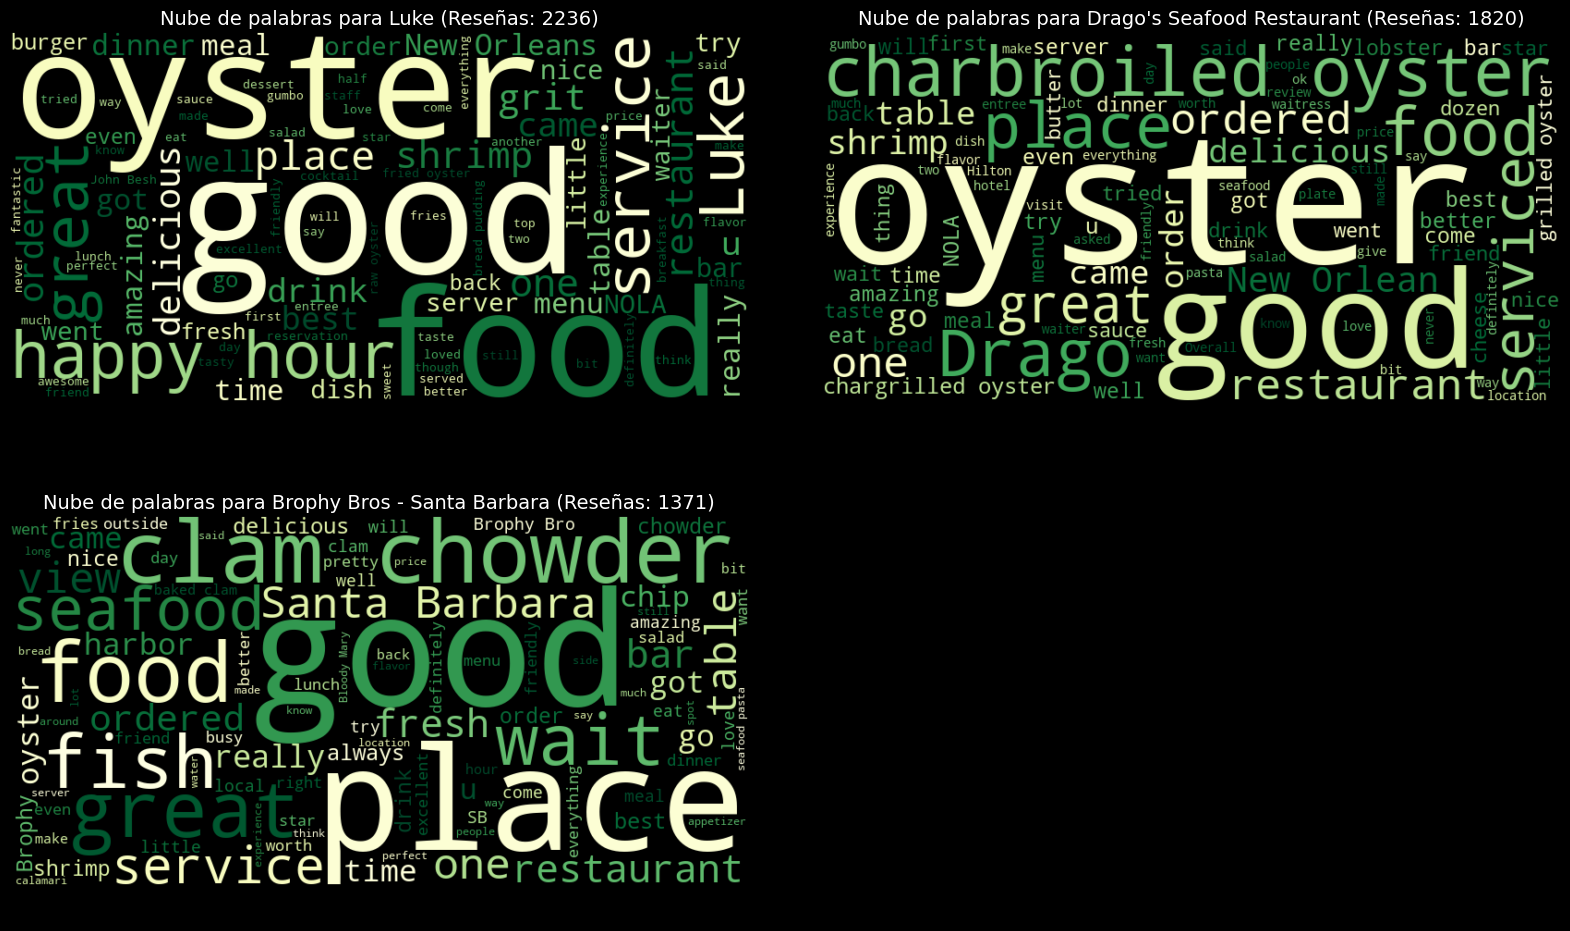

In [37]:
import polars as pl
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear subgráficos con 2 filas y 2 columnas (dejaremos uno vacío)
fig, axes = plt.subplots(2, 2, figsize=(20, 12))  # Establecer el tamaño de la figura y subgráficos

# Establecer fondo negro para la figura
fig.patch.set_facecolor('black')

# Aplanar los ejes para poder iterar fácilmente
axes = axes.flatten()

# Crear una nube de palabras para cada uno de los 3 restaurantes
for idx, row in enumerate(top_3_pensilvania_seafood.iter_rows()):
    name = row[0]
    review_count = row[1]
    
    # Filtrar las reseñas del restaurante actual
    reviews = df_pensilvania.filter(pl.col("name") == name)
    
    # Concatenar todas las reseñas en un solo texto
    text = ' '.join(reviews['text'].to_list())
    
    # Generar la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='black',
                          colormap='YlGn',  # Escala de color verde
                          max_words=100,  # Limitar el número de palabras
                          contour_color='white',  # Contorno blanco
                          contour_width=1).generate(text)
    
    # Mostrar la nube de palabras en el subplot correspondiente
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')  # Sin ejes
    axes[idx].set_title(f"Nube de palabras para {name} (Reseñas: {review_count})", fontsize=14, color='white')

# Dejar el cuarto cuadro vacío
axes[3].axis('off')  # Este cuadro no tendrá contenido

# Cambiar el color de fondo de todos los subgráficos a negro
for ax in axes:
    ax.set_facecolor('black')
    ax.title.set_color('white')  # Cambiar el color del título a blanco

# Ajustar el espacio entre los subgráficos para que no se monten
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Ajusta espacio horizontal y vertical entre subgráficos

# Mostrar el gráfico
plt.show()


In [40]:
# Filtrar el DataFrame original para obtener solo los locales del top 3
top_3_names_pensilvania = top_3_pensilvania_seafood['name'].to_list()

# Calcular el promedio de estrellas para los locales del top 3 en Pensilvania
promedio_estrellas_pensilvania = df_pensilvania.filter(
    pl.col('name').is_in(top_3_names_pensilvania)
).group_by('name').agg(
    pl.col('stars_x').mean().alias('promedio_estrellas')
)

# Mostrar los resultados
print("Promedio de estrellas en los locales del top 3 en Pensilvania:")
print(promedio_estrellas_pensilvania)


Promedio de estrellas en los locales del top 3 en Pensilvania:
shape: (3, 2)
┌─────────────────────────────┬────────────────────┐
│ name                        ┆ promedio_estrellas │
│ ---                         ┆ ---                │
│ str                         ┆ f64                │
╞═════════════════════════════╪════════════════════╡
│ Luke                        ┆ 4.165159           │
│ Brophy Bros - Santa Barbara ┆ 4.082563           │
│ Drago's Seafood Restaurant  ┆ 3.700811           │
└─────────────────────────────┴────────────────────┘


In [41]:
# Convertir a pandas para la gráfica
promedio_estrellas_pennsylvania_pd = promedio_estrellas_pensilvania.to_pandas()

# Crear la representación de lunas para cada restaurante
for index, row in enumerate(promedio_estrellas_pennsylvania_pd.iterrows()):
    stars = row[1]['promedio_estrellas']
    name = row[1]['name']
    
    # Calcular lunas llenas, medias y menguantes
    full_moons = int(stars)  # Lunas llenas
    if stars % 1 >= 0.5:
        half_moon = 1  # Luna media
        waning_moon = 0  # Sin luna menguante
    elif stars % 1 >= 0.1:
        half_moon = 0  # No luna media
        waning_moon = 1  # Luna menguante
    else:
        half_moon = 0  # No luna media
        waning_moon = 0  # Sin luna menguante

    empty_moons = 5 - full_moons - half_moon - waning_moon  # Lunas vacías

    stars_representation = '🌕' * full_moons + ('🌗' * half_moon) + ('🌘' * waning_moon) + ('🌑' * empty_moons)

    # Imprimir la representación de las lunas para cada restaurante
    print(f'{name} - Promedio de Estrellas: {stars:.1f}')
    print(f'Representación de lunas: {stars_representation}\n')


Luke - Promedio de Estrellas: 4.2
Representación de lunas: 🌕🌕🌕🌕🌘

Brophy Bros - Santa Barbara - Promedio de Estrellas: 4.1
Representación de lunas: 🌕🌕🌕🌕🌑

Drago's Seafood Restaurant - Promedio de Estrellas: 3.7
Representación de lunas: 🌕🌕🌕🌗🌑



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KAREN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


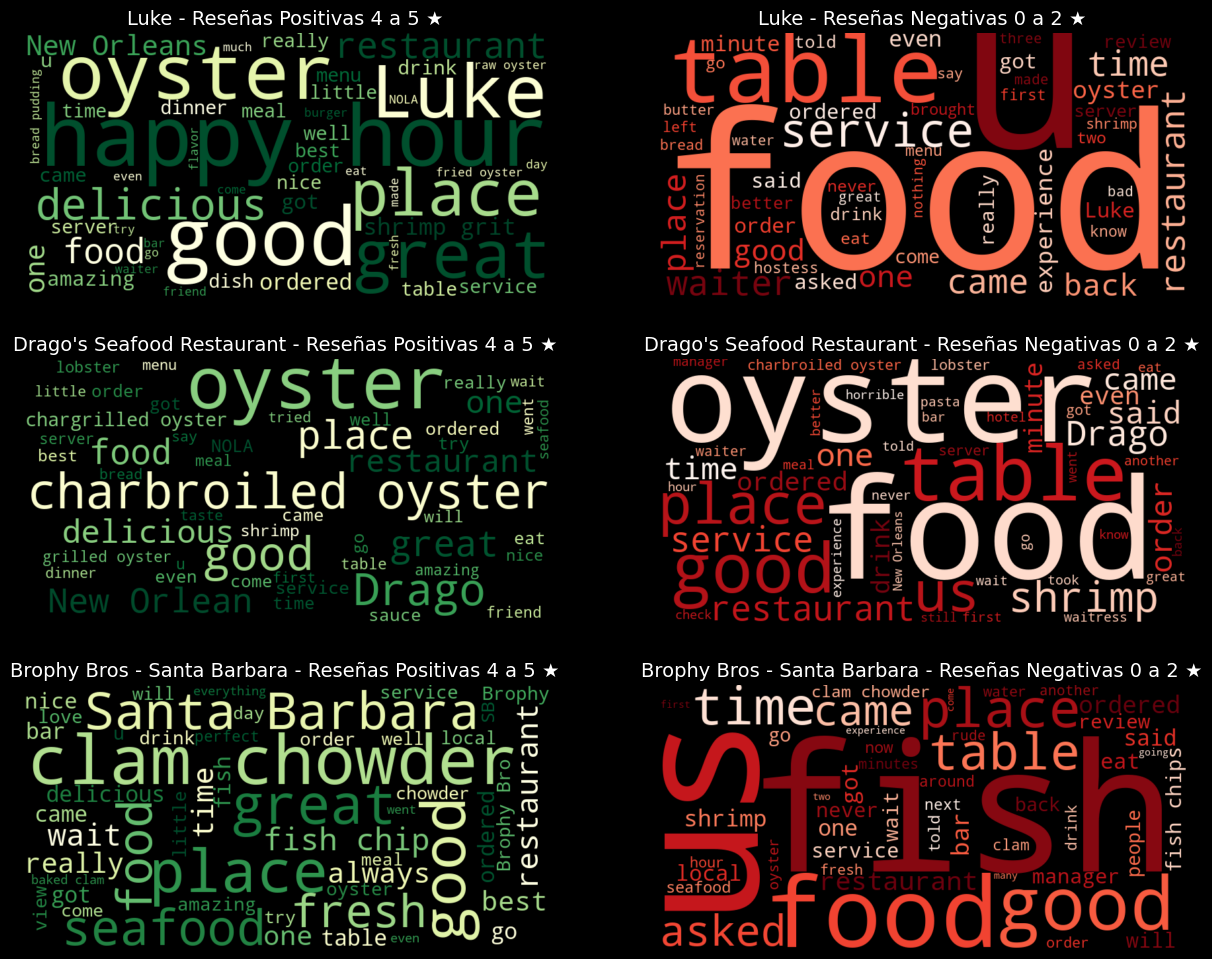

In [45]:
import polars as pl
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from stopwords import get_stopwords

nltk.download('stopwords')

# Obtener las stopwords en inglés
stop_words = set(get_stopwords('en'))

# Función para generar una nube de palabras para reseñas de un restaurante
def generate_wordcloud(reviews, stop_words, color_map='YlGn'):
    # Concatenar todas las reseñas en un solo texto
    text = ' '.join(reviews['text'].to_list())

    # Filtrar las stopwords
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Generar la nube de palabras con fondo negro
    wordcloud = WordCloud(
        width=800, height=400, 
        background_color='black',  # Fondo negro en la nube
        colormap=color_map,  # Usar el colormap que se pase como parámetro
        max_words=50,  # Limitar el número de palabras
        contour_color='white',  # Contorno blanco
        contour_width=1
    ).generate(' '.join(filtered_words))
    
    return wordcloud

# Crear subgráficos con 2 columnas y 3 filas
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # Establecer el tamaño de la figura y subgráficos

# Establecer el fondo de toda la figura a negro
fig.patch.set_facecolor('black')

# Aplanar los ejes para poder iterar fácilmente
axes = axes.flatten()

# Lista de restaurantes (suponiendo que tienes estos nombres en un DataFrame)
restaurants = top_3_pensilvania_seafood['name'].to_list()

# Iterar sobre los restaurantes
for idx, name in enumerate(restaurants):
    # Filtrar las reseñas positivas (4 estrellas o más)
    positive_reviews = df_pensilvania.filter(
        (pl.col("name") == name) & (pl.col("stars_x") >= 4)
    )

    # Filtrar las reseñas negativas (2 estrellas o menos)
    negative_reviews = df_pensilvania.filter(
        (pl.col("name") == name) & (pl.col("stars_x") < 2)
    )

    # Generar la nube de palabras para reseñas positivas (color verde)
    wordcloud_pos = generate_wordcloud(positive_reviews, stop_words, color_map='YlGn')

    # Generar la nube de palabras para reseñas negativas (color rojo)
    wordcloud_neg = generate_wordcloud(negative_reviews, stop_words, color_map='Reds')

    # Mostrar la nube de palabras de reseñas positivas
    axes[2*idx].imshow(wordcloud_pos, interpolation='bilinear')
    axes[2*idx].axis('off')
    axes[2*idx].set_title(f'{name} - Reseñas Positivas 4 a 5 ★ ', fontsize=14, color='white')

    # Mostrar la nube de palabras de reseñas negativas
    axes[2*idx + 1].imshow(wordcloud_neg, interpolation='bilinear')
    axes[2*idx + 1].axis('off')
    axes[2*idx + 1].set_title(f'{name} - Reseñas Negativas 0 a 2 ★', fontsize=14, color='white')

# Cambiar el color de fondo de todos los subgráficos a negro y los títulos a blanco
for ax in axes:
    ax.set_facecolor('black')
    ax.title.set_color('white')  # Cambiar el color del título a blanco

# Ajustar el espacio entre los subgráficos para que no se monten
plt.subplots_adjust(wspace=0.2, hspace=0.2)  # Ajusta espacio horizontal y vertical entre subgráficos

# Mostrar el gráfico
plt.show()


In [62]:
print(df_florida.head(1))
print(df_florida.shape)

shape: (1, 17)
┌────────────┬────────────┬────────────┬─────────┬───┬────────────┬────────────┬────────────┬──────┐
│ review_id  ┆ user_id    ┆ business_i ┆ stars_x ┆ … ┆ review_cou ┆ day_of_wee ┆ hour_of_da ┆ year │
│ ---        ┆ ---        ┆ d          ┆ ---     ┆   ┆ nt         ┆ k          ┆ y          ┆ ---  │
│ str        ┆ str        ┆ ---        ┆ i64     ┆   ┆ ---        ┆ ---        ┆ ---        ┆ i32  │
│            ┆            ┆ str        ┆         ┆   ┆ i64        ┆ i8         ┆ i8         ┆      │
╞════════════╪════════════╪════════════╪═════════╪═══╪════════════╪════════════╪════════════╪══════╡
│ pUycOfUwM8 ┆ 59MxRhNVhU ┆ gebiRewfie ┆ 3       ┆ … ┆ 488        ┆ 1          ┆ 7          ┆ 2016 │
│ vqX7KjRRhU ┆ 9MYndMkz0w ┆ Sdtt17PTW6 ┆         ┆   ┆            ┆            ┆            ┆      │
│ EA         ┆ tw         ┆ Zg         ┆         ┆   ┆            ┆            ┆            ┆      │
└────────────┴────────────┴────────────┴─────────┴───┴────────────┴─────────

In [63]:
# Obtener los 3 locales más frecuentes con categoría para cada estado
top_3_florida = top_3_seafood_places(df_florida, seafood_keywords)

# Filtrar los resultados para quedarnos solo con aquellos que contengan 'Seafood' en las categorías
top_3_florida_seafood = top_3_florida.filter(
    pl.col("category").list.contains("Seafood")
)

print("\nTop 3 locales de mariscos en Florida que contienen 'Seafood' en categorías:")
print(top_3_florida_seafood)


Top 3 locales de mariscos en Florida que contienen 'Seafood' en categorías:
shape: (3, 3)
┌───────────────┬──────────────┬─────────────────────────────────┐
│ name          ┆ review_count ┆ category                        │
│ ---           ┆ ---          ┆ ---                             │
│ str           ┆ u32          ┆ list[str]                       │
╞═══════════════╪══════════════╪═════════════════════════════════╡
│ Oceana Grill  ┆ 2481         ┆ ["Restaurants", "Seafood", … "… │
│ Oyster House  ┆ 1144         ┆ ["Restaurants", "Steakhouses",… │
│ Bourbon House ┆ 934          ┆ ["Restaurants", "Cajun/Creole"… │
└───────────────┴──────────────┴─────────────────────────────────┘


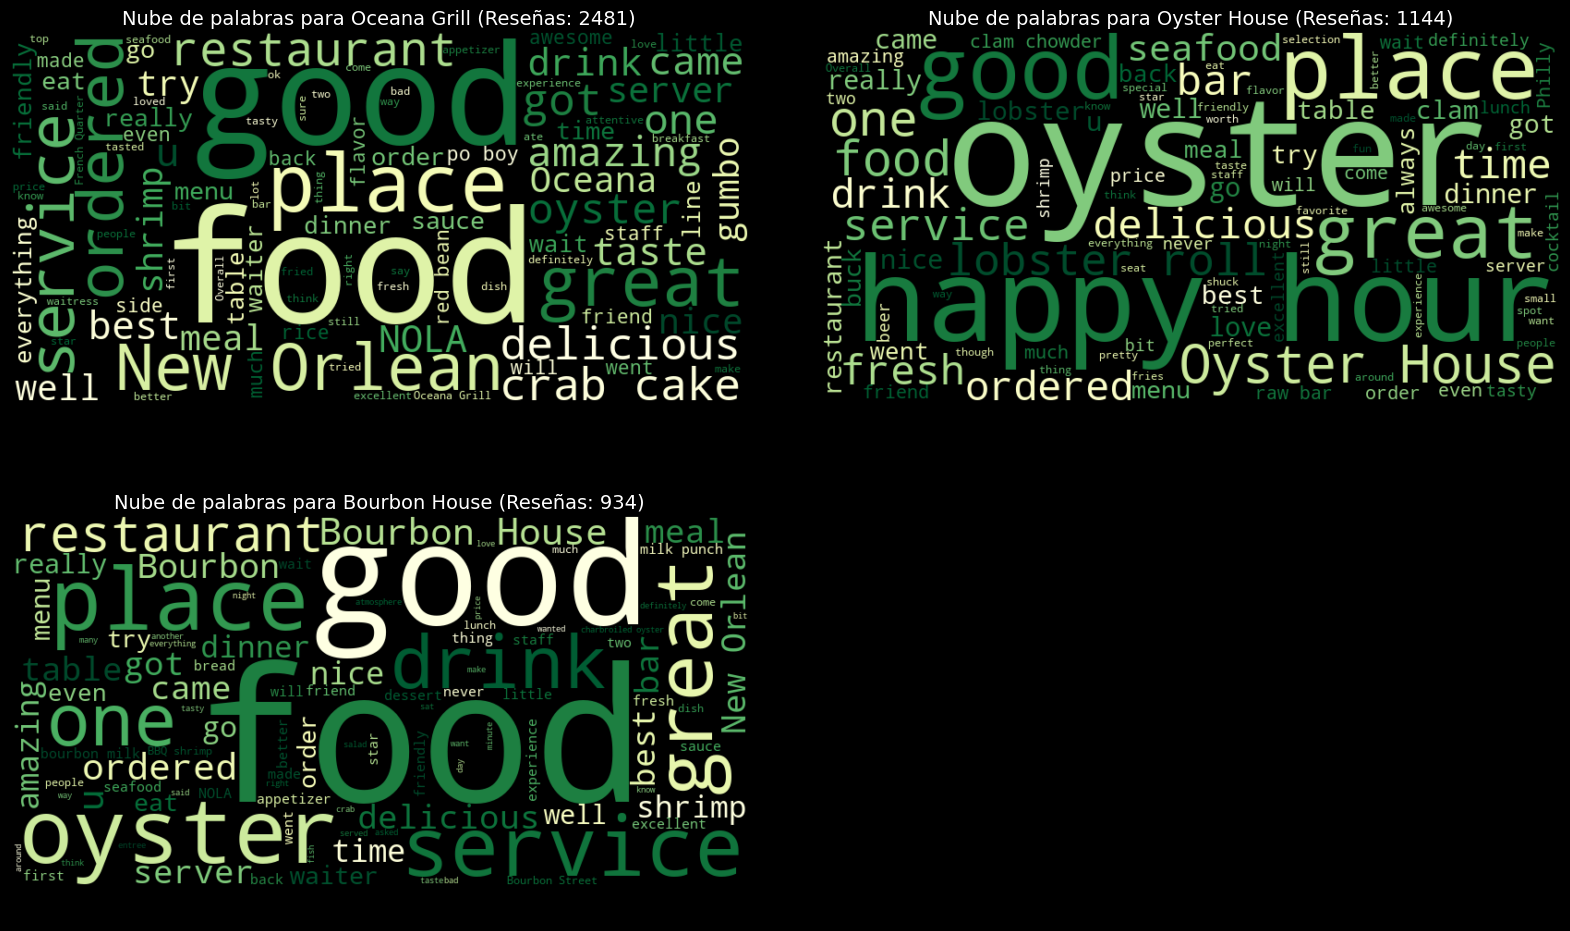

In [64]:
import polars as pl
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear subgráficos con 2 filas y 2 columnas (dejaremos uno vacío)
fig, axes = plt.subplots(2, 2, figsize=(20, 12))  # Establecer el tamaño de la figura y subgráficos

# Establecer fondo negro para la figura
fig.patch.set_facecolor('black')

# Aplanar los ejes para poder iterar fácilmente
axes = axes.flatten()

# Crear una nube de palabras para cada uno de los 3 restaurantes en Florida
for idx, row in enumerate(top_3_florida_seafood.iter_rows()):
    name = row[0]
    review_count = row[1]
    
    # Filtrar las reseñas del restaurante actual
    reviews = df_florida.filter(pl.col("name") == name)
    
    # Concatenar todas las reseñas en un solo texto
    text = ' '.join(reviews['text'].to_list())
    
    # Generar la nube de palabras
    wordcloud = WordCloud(
        width=800, height=400, 
        background_color='black',
        colormap='YlGn',  # Escala de color verde
        max_words=100,  # Limitar el número de palabras
        contour_color='white',  # Contorno blanco
        contour_width=1
    ).generate(text)
    
    # Mostrar la nube de palabras en el subplot correspondiente
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')  # Sin ejes
    axes[idx].set_title(f"Nube de palabras para {name} (Reseñas: {review_count})", fontsize=14, color='white')

# Dejar el cuarto cuadro vacío
axes[3].axis('off')  # Este cuadro no tendrá contenido

# Cambiar el color de fondo de todos los subgráficos a negro
for ax in axes:
    ax.set_facecolor('black')
    ax.title.set_color('white')  # Cambiar el color del título a blanco

# Ajustar el espacio entre los subgráficos para que no se monten
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Ajusta espacio horizontal y vertical entre subgráficos

# Mostrar el gráfico
plt.show()


In [65]:
# Filtrar el DataFrame original para obtener solo los locales del top 3
top_3_names_florida = top_3_florida_seafood['name'].to_list()

# Calcular el promedio de estrellas para los locales del top 3 en Florida
promedio_estrellas_florida = df_florida.filter(
    pl.col('name').is_in(top_3_names_florida)
).group_by('name').agg(
    pl.col('stars_x').mean().alias('promedio_estrellas')
)

# Mostrar los resultados
print("Promedio de estrellas en los locales del top 3 en Florida:")
print(promedio_estrellas_florida)


Promedio de estrellas en los locales del top 3 en Florida:
shape: (3, 2)
┌───────────────┬────────────────────┐
│ name          ┆ promedio_estrellas │
│ ---           ┆ ---                │
│ str           ┆ f64                │
╞═══════════════╪════════════════════╡
│ Bourbon House ┆ 3.696151           │
│ Oyster House  ┆ 4.235392           │
│ Oceana Grill  ┆ 3.959714           │
└───────────────┴────────────────────┘


In [ ]:
# Convertir el DataFrame de Polars a pandas para facilitar el procesamiento en bucle
promedio_estrellas_florida_pd = promedio_estrellas_florida.to_pandas()

# Crear la representación de lunas para cada restaurante en el top 3 de Florida
for _, row in promedio_estrellas_florida_pd.iterrows():
    stars = row['promedio_estrellas']
    name = row['name']
    
    # Calcular el número de lunas llenas, medias y menguantes según el promedio de estrellas
    full_moons = int(stars)  # Lunas llenas
    if stars % 1 >= 0.5:
        half_moon = 1  # Luna media
        waning_moon = 0  # Sin luna menguante
    elif stars % 1 >= 0.1:
        half_moon = 0  # No luna media
        waning_moon = 1  # Luna menguante
    else:
        half_moon = 0  # No luna media
        waning_moon = 0  # Sin luna menguante

    empty_moons = 5 - full_moons - half_moon - waning_moon  # Lunas vacías para completar las 5

    # Crear la representación de lunas para el promedio de estrellas del restaurante
    stars_representation = '🌕' * full_moons + ('🌗' * half_moon) + ('🌘' * waning_moon) + ('🌑' * empty_moons)

    # Imprimir el nombre del restaurante, su promedio de estrellas y la representación con lunas
    print(f'{name} - Promedio de Estrellas: {stars:.1f}')
    print(f'Representación de lunas: {stars_representation}\n')

Bourbon House - Promedio de Estrellas: 3.7
Representación de lunas: 🌕🌕🌕🌗🌑

Oyster House - Promedio de Estrellas: 4.2
Representación de lunas: 🌕🌕🌕🌕🌘

Oceana Grill - Promedio de Estrellas: 4.0
Representación de lunas: 🌕🌕🌕🌗🌑



In [11]:
print(df_tenesse.head(1))
print(df_tenesse.shape)


KeyboardInterrupt



In [21]:
# Obtener los 3 locales más frecuentes con categoría para cada estado
top_3_tennessee = top_3_seafood_places(df_tenesse, seafood_keywords)

# Filtrar los resultados para quedarnos solo con aquellos que contengan 'Seafood' en las categorías
top_3_tennessee_seafood = top_3_tennessee.filter(
    pl.col("category").list.contains("Seafood")
)

# Eliminar el tercer resultado específico (St. Elmo Steak House)
top_3_tennessee_seafood = top_3_tennessee_seafood.filter(
    pl.col("name") != "St. Elmo Steak House"
)

print("\nTop 3 locales de mariscos en Tennessee que contienen 'Seafood' en categorías:")
print(top_3_tennessee_seafood)



Top 3 locales de mariscos en Tennessee que contienen 'Seafood' en categorías:
shape: (3, 3)
┌─────────────────────────────────┬──────────────┬─────────────────────────────────┐
│ name                            ┆ review_count ┆ category                        │
│ ---                             ┆ ---          ┆ ---                             │
│ str                             ┆ u32          ┆ list[str]                       │
╞═════════════════════════════════╪══════════════╪═════════════════════════════════╡
│ GW Fins                         ┆ 1107         ┆ ["Seafood", "Gluten-Free", … "… │
│ Santa Barbara Shellfish Compan… ┆ 1089         ┆ ["Live/Raw Food", "Restaurants… │
│ Frenchy's Rockaway Grill        ┆ 806          ┆ ["Sandwiches", "American (Trad… │
└─────────────────────────────────┴──────────────┴─────────────────────────────────┘


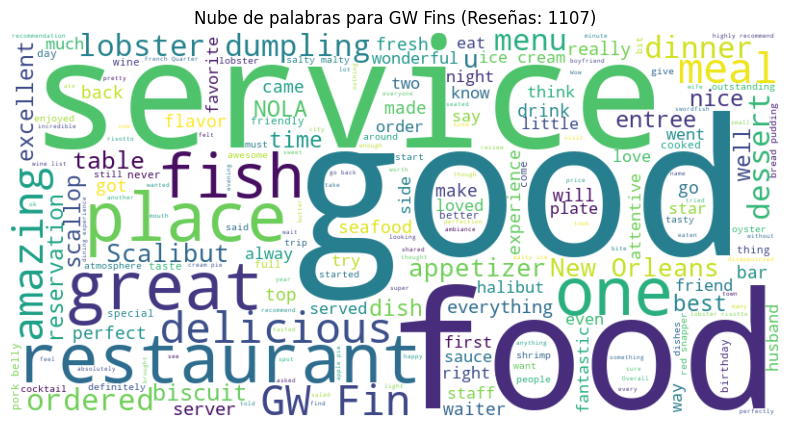

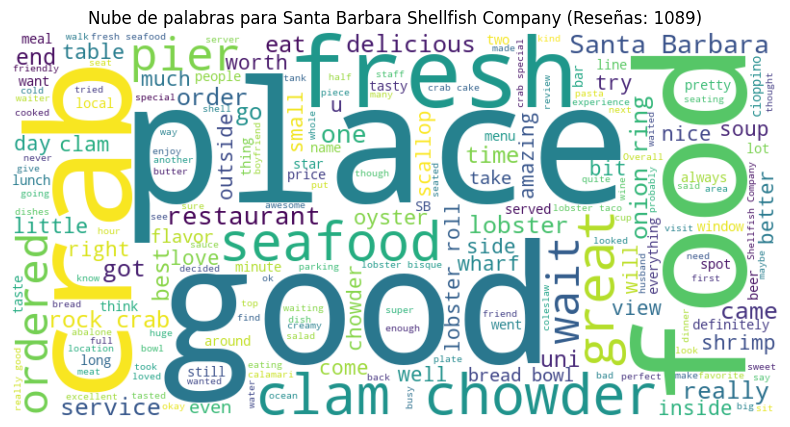

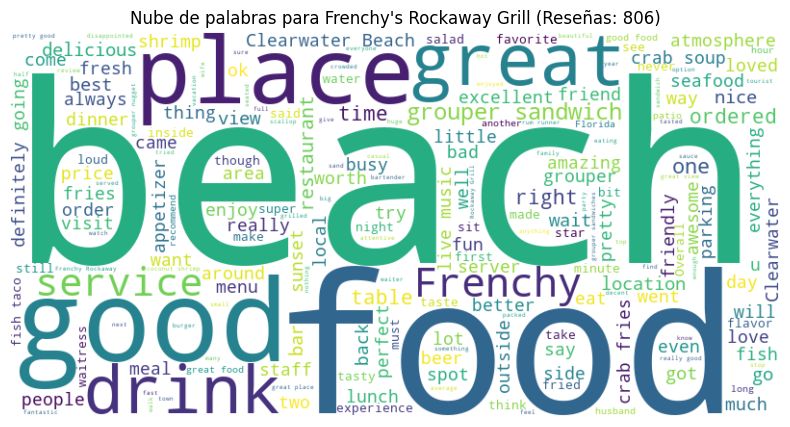

In [26]:
# Crear una nube de palabras para cada uno de los 3 restaurantes
for idx, row in enumerate(top_3_tennessee_seafood.iter_rows()):
    name = row[0]
    review_count = row[1]
    category = row[2]
    
    # Filtrar el DataFrame original para obtener las reseñas del restaurante actual
    reviews = df_tenesse.filter(pl.col("name") == name)

    # Concatenar todas las reseñas en un solo texto
    text = ' '.join(reviews['text'].to_list())
    
    # Generar la nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Sin ejes
    plt.title(f"Nube de palabras para {name} (Reseñas: {review_count})")
    plt.show()

In [27]:
# Filtrar el DataFrame original para obtener solo los locales del top 3
top_3_names_tennessee = top_3_tennessee_seafood['name'].to_list()

# Calcular el promedio de estrellas para los locales del top 3 en Tennessee
promedio_estrellas_tennessee = df_tenesse.filter(
    pl.col('name').is_in(top_3_names_tennessee)
).group_by('name').agg(
    pl.col('stars_x').mean().alias('promedio_estrellas')
)

# Mostrar los resultados
print("Promedio de estrellas en los locales del top 3 en Tennessee:")
print(promedio_estrellas_tennessee)

Promedio de estrellas en los locales del top 3 en Tennessee:
shape: (3, 2)
┌─────────────────────────────────┬────────────────────┐
│ name                            ┆ promedio_estrellas │
│ ---                             ┆ ---                │
│ str                             ┆ f64                │
╞═════════════════════════════════╪════════════════════╡
│ Santa Barbara Shellfish Compan… ┆ 3.980492           │
│ GW Fins                         ┆ 4.552126           │
│ Frenchy's Rockaway Grill        ┆ 3.971724           │
└─────────────────────────────────┴────────────────────┘


In [ ]:
# Convertir a pandas para la gráfica
promedio_estrellas_tennessee_pd = promedio_estrellas_tennessee.to_pandas()

# Crear la figura para Florida
fig_tennessee = go.Figure()

# Añadir las representaciones de lunas para Florida
for index, row in promedio_estrellas_tennessee_pd.iterrows():
    stars = row['promedio_estrellas']
    name = row['name']
    
    # Calcular lunas llenas, medias y menguantes
    full_moons = int(stars)  # Lunas llenas
    if stars % 1 >= 0.5:
        half_moon = 1  # Luna media
        waning_moon = 0  # Sin luna menguante
    elif stars % 1 >= 0.1:
        half_moon = 0  # No luna media
        waning_moon = 1  # Luna menguante
    else:
        half_moon = 0  # No luna media
        waning_moon = 0  # Sin luna menguante

    empty_moons = 5 - full_moons - half_moon - waning_moon  # Lunas vacías

    stars_representation = '🌕' * full_moons + ('🌗' * half_moon) + ('🌘' * waning_moon) + ('🌑' * empty_moons)

    fig_tennessee.add_trace(go.Bar(
        x=[name],
        y=[stars],
        name=stars_representation,
        hovertemplate=f'{name}: {stars:.2f} Estrellas<br>{stars_representation}',
        text=stars_representation,
        textposition='inside'
    ))

# Ajustes del layout para Florida
fig_tennessee.update_layout(
    title='Promedio de Estrellas por Restaurante en Florida',
    xaxis_title='Restaurante',
    yaxis_title='Promedio de Estrellas',
    yaxis=dict(range=[0, 5]),
    showlegend=False,
    margin=dict(l=40, r=40, t=40, b=40)
)

# Mostrar la gráfica para Florida
fig_tennessee.show()
